In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import pandas as pd
# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Required deep learning libraries
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,Dense, Flatten,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import keras
from tensorflow.keras import Model


In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

### image paths

In [ ]:
os.chdir("/content/drive/MyDrive/task/Data")
trainCSV_Data = "styles.csv"
trainImage    = "images"
# testCSV_Data  = "../data/myntradataset/styles.csv"
# testImage     = "../data/myntradataset/images/"

### reading csv data

In [ ]:
traindata = pd.read_csv(trainCSV_Data,nrows=5000, error_bad_lines=False)
traindata.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt


In [ ]:
# adding .jpg after id for every image
traindata['image'] = traindata['id'].map(lambda x: str(x) + '.jpg')

In [ ]:
# concatenating subCategory+articleType=type
traindata['type']=traindata['subCategory']+" "+traindata['articleType']
# cleaning dataset
traindata.drop(['gender','masterCategory','baseColour','season','year','usage','productDisplayName','subCategory','articleType'],axis=1,inplace=True)

In [ ]:
# final dataset
traindata.head()

,id,image,type
0,15970,15970.jpg,Topwear Shirts
1,39386,39386.jpg,Bottomwear Jeans
2,59263,59263.jpg,Watches Watches
3,21379,21379.jpg,Bottomwear Track Pants
4,53759,53759.jpg,Topwear Tshirts


In [ ]:
print(f"Total data rows: {len(traindata)}")
print(f"Total number of equnique fashion type: {len(traindata['type'].unique())}")
print("Total number of fashion type which has value count less than 120: ",len(traindata.groupby("type").filter(lambda x : len(x)<100)))

Total data rows: 5000
Total number of equnique fashion type: 111
Total number of fashion type which has value count less than 120:  1746


In [ ]:
traindata = traindata.groupby("type").filter(lambda x : len(x)>120)

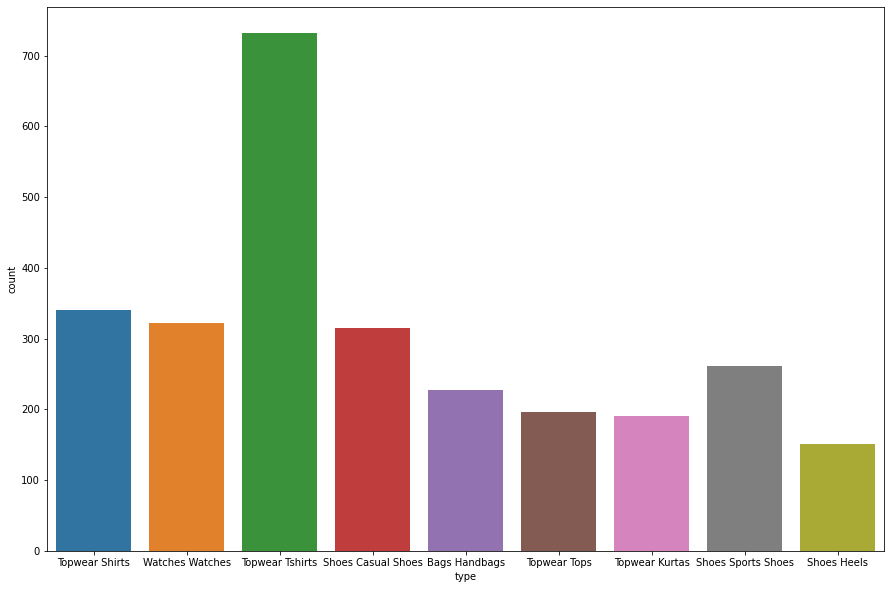

In [ ]:
plt.figure(figsize=(15,10))
sns.countplot(traindata.type)

# sample images

In [ ]:
# images, labels = traindata[:20]["image"].tolist(), traindata[:20]["type"].tolist()
# # Plot the image grid
# plt.figure(figsize = (20,20))
# for i in range(20):
#     plt.subplot(5,4,i+1)
#     img = cv2.imread(trainImage + images[i])
#     img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#     plt.imshow(img)
#     plt.title(labels[i])

In [ ]:
train,test = train_test_split(traindata,test_size=0.2, random_state=42)

In [ ]:
print("shape of training data: ", train.shape)
print("shape of test data: ", test.shape)

shape of training data:  (2187, 3)
shape of test data:  (547, 3)


In [ ]:
BATCH_SIZE   = 64
EPOCHS       = 100
TARGET_SIZE  = 128
num_features = 128
num_labels   = 9
batch_size   = 64

### Augment Image Data

In [ ]:
train_datagen = ImageDataGenerator(validation_split                = 0.2,
                                    width_shift_range = 0.2,height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.3,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(train,
                         directory   = os.path.join(trainImage),
                         subset      = "training",
                         x_col       = "image",
                         y_col       = "type",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size  = BATCH_SIZE,
                         class_mode  = "sparse")


Found 988 validated image filenames belonging to 9 classes.


In [ ]:
validation_datagen = ImageDataGenerator(validation_split = 0.2)

validation_generator = validation_datagen.flow_from_dataframe(train,
                       directory    = os.path.join(trainImage),
                       subset       = "validation",
                       x_col        = "image",
                       y_col        = "type",
                       target_size  = (TARGET_SIZE, TARGET_SIZE),
                       batch_size   = BATCH_SIZE,
                       class_mode   = "sparse")

Found 247 validated image filenames belonging to 9 classes.


Found 1 validated image filenames belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

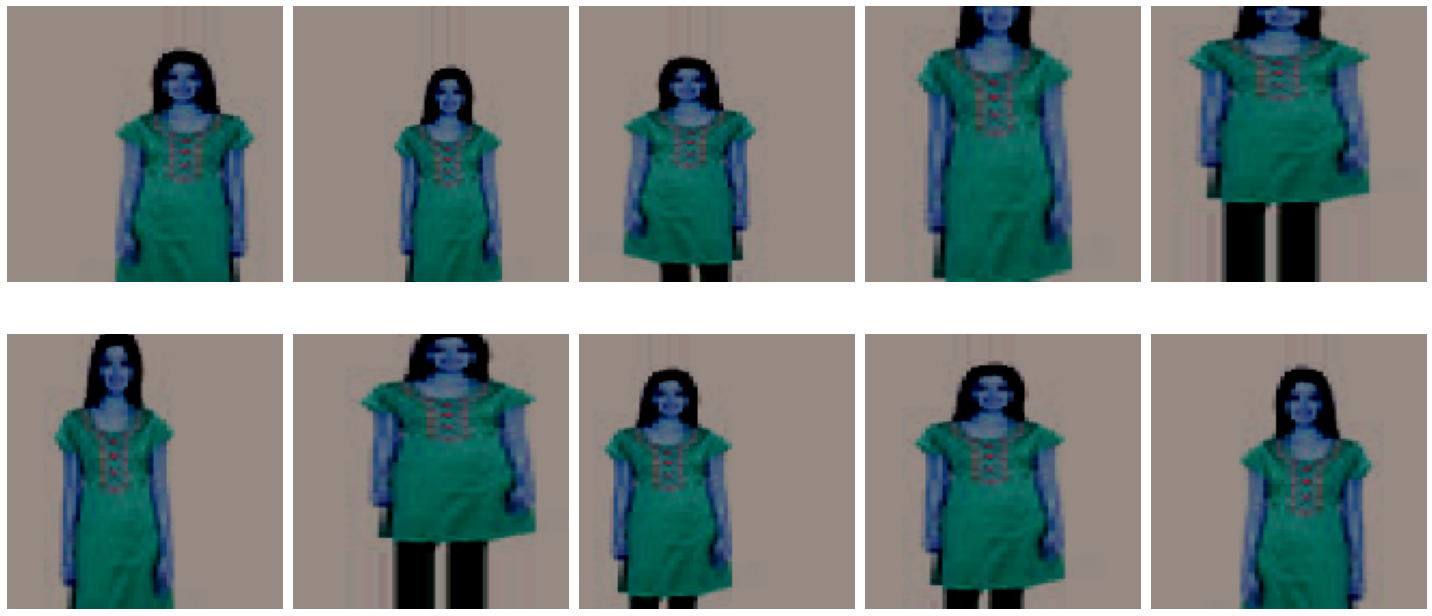

In [ ]:
generator = train_datagen.flow_from_dataframe(traindata.iloc[20:21],
                         directory     = os.path.join(trainImage),
                         x_col         = "image",
                         y_col         = "type",
                         target_size   = (TARGET_SIZE, TARGET_SIZE),
                         batch_size    = BATCH_SIZE,
                         class_mode    = "sparse")

aug_images = [generator[0][0][0]/255 for i in range(10)]
fig, axes  = plt.subplots(2, 5, figsize = (20, 10))
axes       = axes.flatten()

for img, ax in zip(aug_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

### callback function

In [ ]:
ACCURACY_THRESHOLD = 0.9

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc') > ACCURACY_THRESHOLD):
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))
            self.model.stop_training = True

# Instantiate a callback object
callbacks = myCallback()

In [ ]:
# Loss curve
def lossCurve(history):
  plt.plot(history.history['loss'],'r',linewidth=3.0)
  plt.plot(history.history['val_loss'],'b',linewidth=3.0)
  plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
  plt.xlabel('Epochs ',fontsize=16)
  plt.ylabel('Loss',fontsize=16)
  plt.title('Loss Curves',fontsize=16)
    

In [ ]:
# accuracy curve
def accuracyCurve(history):
  plt.plot(history.history['acc'],'r',linewidth=3.0) 
  plt.plot(history.history['val_acc'],'b',linewidth=3.0) 
  plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18) 
  plt.xlabel('Epochs ',fontsize=16) 
  plt.ylabel('Accuracy',fontsize=16) 
  plt.title('Accuracy Curves',fontsize=16)

In [ ]:
# Curve gride
def plotSummary(history):
    plt.figure(figsize=[18,10]) 
    plt.subplot(121)
    # Model summary of loss and accuray during training with data
    lossCurve(history)
    #Plot the Accuracy Curves
    plt.subplot(122)
    accuracyCurve(history)

#  Model

In [ ]:
def VGG16_Model():
    
    vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(TARGET_SIZE, TARGET_SIZE,3))

    for layer in vgg_model.layers:
        layer.trainable = False
    x = Flatten()(vgg_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_labels, activation='softmax')(x)
    
    model = Model(vgg_model.input, x)
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics = ['acc'])
    return model

In [ ]:
model = VGG16_Model()
#model3.summary()

58892288/58889256 [==============================] - 0s 0us/step


Epoch 1/100
16/16 [==============================] - 532s 33s/step - loss: 22.5751 - acc: 0.4290 - val_loss: 2.7926 - val_acc: 0.7935
Epoch 2/100
16/16 [==============================] - 7s 413ms/step - loss: 2.8647 - acc: 0.6779 - val_loss: 1.9163 - val_acc: 0.7773
Epoch 3/100
16/16 [==============================] - 7s 407ms/step - loss: 1.5695 - acc: 0.7411 - val_loss: 1.5396 - val_acc: 0.7409
Epoch 4/100
16/16 [==============================] - 7s 403ms/step - loss: 1.5403 - acc: 0.7207 - val_loss: 1.1506 - val_acc: 0.7530
Epoch 5/100
16/16 [==============================] - 7s 408ms/step - loss: 1.2101 - acc: 0.7774 - val_loss: 1.1601 - val_acc: 0.7692
Epoch 6/100
16/16 [==============================] - 7s 416ms/step - loss: 1.2483 - acc: 0.7615 - val_loss: 1.5945 - val_acc: 0.7571
Epoch 7/100
16/16 [==============================] - 7s 416ms/step - loss: 1.0262 - acc: 0.7800 - val_loss: 1.1392 - val_acc: 0.8057
Epoch 8/100
16/16 [==============================] - 7s 414ms/step -

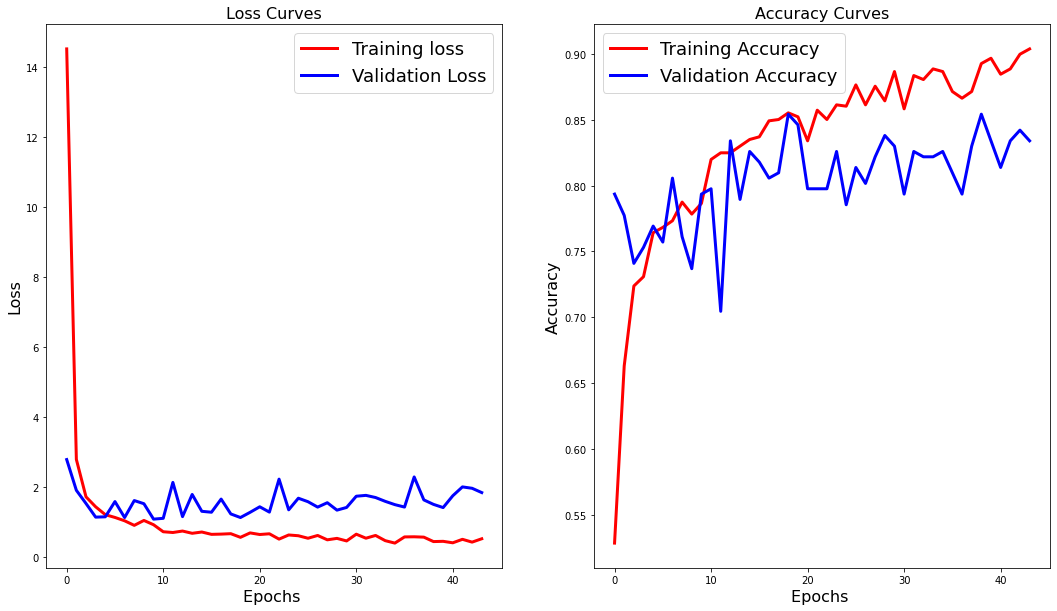

In [ ]:
history = model.fit( train_generator,epochs=EPOCHS,verbose=1,validation_data = validation_generator,batch_size = BATCH_SIZE,callbacks=[callbacks])
plotSummary(history)

In [ ]:
# all the class labels
classes = {v: k for k, v in train_generator.class_indices .items()} 

In [ ]:
classes

{0: 'Bags Handbags',
 1: 'Shoes Casual Shoes',
 2: 'Shoes Heels',
 3: 'Shoes Sports Shoes',
 4: 'Topwear Kurtas',
 5: 'Topwear Shirts',
 6: 'Topwear Tops',
 7: 'Topwear Tshirts',
 8: 'Watches Watches'}

# predition

Text(0.5, 1.0, 'Shoes Casual Shoes')

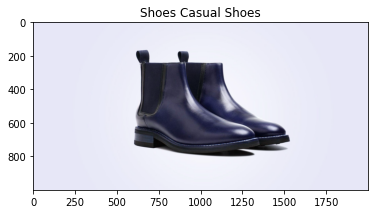

In [ ]:
testImage = "/content/best-shoes-1610418585.jpg"
img = cv2.imread(testImage)
plt.imshow(img)
img.resize((TARGET_SIZE, TARGET_SIZE,3))
image = np.expand_dims(img, axis=0)
pred = model.predict(image)
plt.title(classes[np.argmax(pred)])

In [ ]:

# Saving weights of the model to a HDF5 file 
model.save("fashion.h5") 

In [ ]:
from keras.models import load_model

In [ ]:
import h5py

model = load_model('/content/drive/MyDrive/task/Data/fashion.h5')